# Install dependencies

In [ ]:
!pip install pretrainedmodels
!pip install albumentations==0.4.5

     |████████████████████████████████| 61kB 4.0MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp37-none-any.whl size=60963 sha256=30bc806145b3e8feb8ac06611a23dfcf0503aa3d54d17ca23bec3a9429015671
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels
     |████████████████████████████████| 122kB 7.2MB/s 
     |████████████████████████████████| 634kB 12.0MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp37-none-any.whl size=64378 sha256=595bc1dcfd86e12f30807299092978000597c4f50a03636d7a45344d53189278
  Stored in directory: /root/.cache/pip/wheels/f0/a0/61/e50f93165a5ec7e7f5d65064e513239505bc4c06d2289557d3
  Created wheel for imgaug: filename=imgaug-0.2.6-cp37-none-any.whl size=654019 sha256=9bdfe6fad796a688884730d599491a37f67da626e9e0339f38cef64c4e748ad4
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.3MB 7.4MB/s 
     |████████████████████████████████| 3.3MB 42.6MB/s 
     |████████████████████████████████| 901kB 50.2MB/s 


In [ ]:
# install dependencies for TPU
#!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
#!python pytorch-xla-env-setup.py --apt-packages libomp5 libopenblas-dev

# Download data

In [ ]:
# https://drive.google.com/file/d/1jfkX_NXF8shxyWZCxJkzsLPDr4ebvdOP/view?usp=sharing
!pip install gdown
!gdown https://drive.google.com/uc?id=1jfkX_NXF8shxyWZCxJkzsLPDr4ebvdOP
!unzip -q plant-pathology-2020-fgvc7.zip -d /content/plant-pathology-2020-fgvc7
!rm plant-pathology-2020-fgvc7.zip

Downloading...
From: https://drive.google.com/uc?id=1jfkX_NXF8shxyWZCxJkzsLPDr4ebvdOP
To: /content/plant-pathology-2020-fgvc7.zip
817MB [00:04, 199MB/s]


# Import libraries

In [ ]:
# Import os
import os

# Import libraries for data manipulation
import numpy as np
import pandas as pd

# Import libries for data agumentations: albumentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensor
from albumentations import Rotate 
import cv2 as cv

# Import Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader

# Import pretrainmodels
import pretrainedmodels

# Import transformers
from transformers import get_cosine_schedule_with_warmup
from transformers import AdamW

# Import metrics for model evaluation
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

# Import libraries for data visualization
import matplotlib.pyplot as plt

# Import tqdm.notebook for loading visualization
from tqdm.notebook import tqdm

# Ignore warnings
import warnings  
warnings.filterwarnings('ignore')

In [ ]:
# Import for TPU configuration
#import torch_xla
#import torch_xla.core.xla_model as xm

# Settings

In [ ]:
# Configuration path

# Data folder
IMAGES_PATH = '/content/plant-pathology-2020-fgvc7/images/'

# Sample submission csv
SAMPLE_SUBMISSION = '/content/plant-pathology-2020-fgvc7/sample_submission.csv'

# Train, test data path
TRAIN_DATA = '/content/plant-pathology-2020-fgvc7/train.csv'
TEST_DATA = '/content/plant-pathology-2020-fgvc7/test.csv'

In [ ]:
# Configuration for training workflow
SEED = 1234
N_FOLDS = 5
N_EPOCHS = 20
BATCH_SIZE = 2
SIZE = 512
IMG_SHAPE = (1365, 2048, 3)
lr = 8e-4

In [ ]:
submission_df = pd.read_csv(SAMPLE_SUBMISSION)
df_train = pd.read_csv(TRAIN_DATA)
df_test = pd.read_csv(TEST_DATA)

def get_image_path(filename):
    return (IMAGES_PATH + filename + '.jpg')

#df_train['image_path'] = df_train['image_id'].apply(get_image_path)
#df_test['image_path'] = df_test['image_id'].apply(get_image_path)
#rain_labels = df_train.loc[:, 'healthy':'scab']
#train_paths = df_train.image_path
#test_paths = df_test.image_path

In [ ]:
df_train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [ ]:
df_test.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


In [ ]:
submission_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.25,0.25,0.25,0.25
1,Test_1,0.25,0.25,0.25,0.25
2,Test_2,0.25,0.25,0.25,0.25
3,Test_3,0.25,0.25,0.25,0.25
4,Test_4,0.25,0.25,0.25,0.25


In [ ]:
# for GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device


# for TPU
#device = xm.xla_device()
#torch.set_default_tensor_type('torch.FloatTensor')
#device

device(type='cuda', index=0)

# Define Dataset

In [ ]:
class PlantDataset(Dataset):
    
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms=transforms
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        # Solution 01: Read from raw image
        image_src = IMAGES_PATH + self.df.loc[idx, 'image_id'] + '.jpg'

        # Solution 02: Read from npy file, we convert all images in images folder from .jpg to .npy
        # image_src = np.load(IMAGES_PATH + self.df.loc[idx, 'image_id'] + '.npy')

        # print(image_src)
        image = cv.imread(image_src, cv.IMREAD_COLOR)
        if image.shape != IMG_SHAPE:
            image = image.transpose(1, 0, 2)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        labels = self.df.loc[idx, ['healthy', 'multiple_diseases', 'rust', 'scab']].values
        labels = torch.from_numpy(labels.astype(np.int8))
        labels = labels.unsqueeze(-1)
        
        if self.transforms:
            transformed = self.transforms(image=image)
            image = transformed['image']

        return image, labels

# Data Agumentations

In [ ]:
# Train transformation
transforms_train = A.Compose([
        A.RandomResizedCrop(height=SIZE, width=SIZE, p=1.0),
        A.OneOf([A.RandomBrightness(limit=0.1, p=1), A.RandomContrast(limit=0.1, p=1)]),
            A.OneOf([A.MotionBlur(blur_limit=3), A.MedianBlur(blur_limit=3), A.GaussianBlur(blur_limit=3)], p=0.5),
            A.VerticalFlip(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(
                shift_limit=0.2,
                scale_limit=0.2,
                rotate_limit=20,
                interpolation=cv.INTER_LINEAR,
                border_mode=cv.BORDER_REFLECT_101,
                p=1,
            ),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0),
             A.pytorch.ToTensorV2(p=1.0),
    ], p=1.0)

# Validation transformation
transforms_valid = A.Compose([
    A.Resize(height=SIZE, width=SIZE, p=1.0),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0),
    A.pytorch.ToTensorV2(p=1.0),
])

# StratifiedKFold

In [ ]:
# Get label from df_train
train_labels = df_train.iloc[:, 1:].values
train_y = train_labels[:, 2] + train_labels[:, 3] * 2 + train_labels[:, 1] * 3

In [ ]:
folds = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
oof_preds = np.zeros((df_train.shape[0], 4))

# PretrainedModels

## Define cross entropy loss one hot

In [ ]:
# define cross entropy loss one hot
class CrossEntropyLossOneHot(nn.Module):
    def __init__(self):
        super(CrossEntropyLossOneHot, self).__init__()
        self.log_softmax = nn.LogSoftmax(dim=-1)

    def forward(self, preds, labels):
        return torch.mean(torch.sum(-labels * self.log_softmax(preds), -1))

## Define dense cross entropy

In [ ]:
# define dense cross entropy
class DenseCrossEntropy(nn.Module):

    def __init__(self):
        super(DenseCrossEntropy, self).__init__()
        
        
    def forward(self, logits, labels):
        logits = logits.float()
        labels = labels.float()
        
        logprobs = F.log_softmax(logits, dim=-1)
        
        loss = -labels * logprobs
        loss = loss.sum(-1)

        return loss.mean()

## Define plant model with ResNet34

In [ ]:
# define plant model with ResNet
class PlantModel(nn.Module):
    # define init function
    def __init__(self, num_classes=4):
        super().__init__()
        
        self.backbone = torchvision.models.resnet34(pretrained=True)
        
        in_features = self.backbone.fc.in_features

        self.logit = nn.Linear(in_features, num_classes)
    # define forward function
    def forward(self, x):
        batch_size, C, H, W = x.shape
        
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        
        x = F.adaptive_avg_pool2d(x,1).reshape(batch_size,-1)
        x = F.dropout(x, 0.25, self.training)

        x = self.logit(x)

        return x

# Train for StratifiedKFold

In [ ]:
def train_one_fold(i_fold, model, criterion, optimizer, lr_scheduler, dataloader_train, dataloader_valid):
    
    train_fold_results = []

    for epoch in range(N_EPOCHS):
        # print information
        print('  Epoch {}/{}'.format(epoch + 1, N_EPOCHS))
        print('  ' + ('-' * 20))
        os.system(f'echo \"  Epoch {epoch}\"')

        # call model
        model.train()
        tr_loss = 0

        # looping
        for step, batch in enumerate(dataloader_train):
            # data preparation
            images = batch[0].to(device)
            labels = batch[1].to(device)
          
            # forward pass and calculate loss
            outputs = model(images)
            loss = criterion(outputs, labels.squeeze(-1))

            # backward pass           
            loss.backward()

            tr_loss += loss.item()
            
            # updates
            # for TPU
            #xm.optimizer_step(optimizer, barrier=True)

            # for GPU
            optimizer.step()
            
            # empty gradient
            optimizer.zero_grad()

        # Validate
        model.eval()
        
        # init validation loss, predicted and labels
        val_loss = 0
        val_preds = None
        val_labels = None

        for step, batch in enumerate(dataloader_valid):
            # data preparation
            images = batch[0].to(device)
            labels = batch[1].to(device)

            # labels preparation
            if val_labels is None:
                val_labels = labels.clone().squeeze(-1)
            else:
                val_labels = torch.cat((val_labels, labels.squeeze(-1)), dim=0)

            
            # disable torch grad to calculating normally
            with torch.no_grad():
                # calculate the output
                outputs = model(batch[0].to(device))

                # calculate the loss value
                loss = criterion(outputs, labels.squeeze(-1))
                val_loss += loss.item()

                # predict with softmax activation function
                preds = torch.softmax(outputs, dim=1).data.cpu()
                #preds = torch.softmax(outputs, dim=1).detach().cpu().numpy()

                
                if val_preds is None:
                    val_preds = preds
                else:
                    val_preds = torch.cat((val_preds, preds), dim=0)
           
        # if train mode
        lr_scheduler.step(tr_loss)

        with torch.no_grad():
            train_loss = tr_loss / len(dataloader_train)
            valid_loss = val_loss / len(dataloader_valid)
            valid_score =  roc_auc_score(val_labels.view(-1).cpu(), val_preds.view(-1).cpu(), average='macro')
        # print information
        if epoch % 2 == 0:
          print(f'Fold {i_fold} Epoch {epoch}: train_loss={train_loss:.4f}, valid_loss={valid_loss:.4f}, acc={valid_score:.4f}')
        train_fold_results.append({
            'fold': i_fold,
            'epoch': epoch,
            'train_loss': train_loss,
            'valid_loss': valid_loss,
            'valid_score': valid_score,
        })

    return val_preds, train_fold_results

## Prepare submission file

In [ ]:
submission_df.iloc[:, 1:] = 0

## Dataset test

In [ ]:
dataset_test = PlantDataset(df=submission_df, transforms=transforms_valid)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, num_workers=4, shuffle=False)

# Init model: EfficientNetB5

In [ ]:
# EfficientNetB5
# B5 is the largest EfficientNet variant that fits in GPU memory with batch size 8.
!pip install efficientnet_pytorch

from efficientnet_pytorch import EfficientNet

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-cp37-none-any.whl size=16443 sha256=a892a26c440e5bd908d1011a93001b287ff579cc0b95da55096c809dfe4560c2
  Stored in directory: /root/.cache/pip/wheels/84/27/aa/c46d23c4e8cc72d41283862b1437e0b3ad318417e8ed7d5921
Successfully built efficientnet-pytorch


In [ ]:
model = EfficientNet.from_pretrained('efficientnet-b5')

num_ftrs = model._fc.in_features
model._fc = nn.Sequential(nn.Linear(num_ftrs,1000,bias=True),
                          nn.ReLU(),
                          nn.Dropout(p=0.5),
                          nn.Linear(1000,4, bias = True))

model.to(device)
model

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b5-b6417697.pth



Loaded pretrained weights for efficientnet-b5


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

# Init model: ResNet

In [ ]:
"""
# Download pretrained weights.
# model = PlantModel(num_classes=4)
model = torchvision.models.resnet18(pretrained=True)

# print number of features
num_features = model.fc.in_features
print(num_features)


# custome layers
model.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.5),
    
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    
    nn.Linear(256, 4))

# initialize weights function
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

# apply model with init weights
model.apply(init_weights)

# transfer model to device (cuda:0 mean using GPU, xla mean using TPU, otherwise using CPU)
model = model.to(device)

# Model details
model
"""

'\n# Download pretrained weights.\n# model = PlantModel(num_classes=4)\nmodel = torchvision.models.resnet18(pretrained=True)\n\n# print number of features\nnum_features = model.fc.in_features\nprint(num_features)\n\n\n# custome layers\nmodel.fc = nn.Sequential(\n    nn.Linear(num_features, 512),\n    nn.ReLU(),\n    nn.BatchNorm1d(512),\n    nn.Dropout(0.5),\n    \n    nn.Linear(512, 256),\n    nn.ReLU(),\n    nn.BatchNorm1d(256),\n    nn.Dropout(0.5),\n    \n    nn.Linear(256, 4))\n\n# initialize weights function\ndef init_weights(m):\n    if type(m) == nn.Linear:\n        torch.nn.init.xavier_uniform_(m.weight)\n        m.bias.data.fill_(0.01)\n\n# apply model with init weights\nmodel.apply(init_weights)\n\n# transfer model to device (cuda:0 mean using GPU, xla mean using TPU, otherwise using CPU)\nmodel = model.to(device)\n\n# Model details\nmodel\n'

In [ ]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  120937 KB |  120937 KB |  120937 KB |       0 B  |
|       from large pool |   85888 KB |   85888 KB |   85888 KB |       0 B  |
|       from small pool |   35049 KB |   35049 KB |   35049 KB |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |  120937 KB |  120937 KB |  120937 KB |       0 B  |
|       from large pool |   85888 KB |   85888 KB |   85888 KB |

# Training model

In [ ]:
submissions = None
train_results = []

for i_fold, (train_idx, valid_idx) in enumerate(folds.split(df_train, train_y)):
    # data preparation phase
    print("Fold {}/{}".format(i_fold + 1, N_FOLDS))

    valid = df_train.iloc[valid_idx]
    valid.reset_index(drop=True, inplace=True)

    train = df_train.iloc[train_idx]
    train.reset_index(drop=True, inplace=True)    

    # data transformation phase
    dataset_train = PlantDataset(df=train, transforms=transforms_train)
    dataset_valid = PlantDataset(df=valid, transforms=transforms_valid)

    # data loader phase
    dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, num_workers=4, shuffle=True, pin_memory=True, drop_last=True)
    dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE, num_workers=4, shuffle=False, pin_memory=True, drop_last=False)


    # device = torch.device("cuda:0")    
    model = model.to(device)

    # optimization phase
    criterion = DenseCrossEntropy()

    # optimizer = optim.Adam(model.parameters(), lr=0.001)
    optimizer = AdamW(model.parameters(), lr = lr, weight_decay = 1e-3)

    # lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[int(N_EPOCHS * 0.5), int(N_EPOCHS * 0.75)], gamma=0.1, last_epoch=-1)
    num_train_steps = int(len(dataset_train) / BATCH_SIZE * N_EPOCHS)
    lr_scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=len(dataset_train)/BATCH_SIZE*5, num_training_steps=num_train_steps)
    
    # training in one fold
    val_preds, train_fold_results = train_one_fold(i_fold, model, criterion, optimizer, lr_scheduler, dataloader_train, dataloader_valid)
    oof_preds[valid_idx, :] = val_preds
    
    # calculate the results phase
    train_results = train_results + train_fold_results

    # model evaluation phase
    model.eval()
    test_preds = None

    # looping test dataloader
    for step, batch in enumerate(dataloader_test):

        images = batch[0].to(device, dtype=torch.float)

        # empty torch gradient
        with torch.no_grad():
            outputs = model(images)

            if test_preds is None:
                test_preds = outputs.data.cpu()
            else:
                test_preds = torch.cat((test_preds, outputs.data.cpu()), dim=0)
    
    
    # Save predictions per fold
    submission_df[['healthy', 'multiple_diseases', 'rust', 'scab']] = torch.softmax(test_preds, dim=1)
    submission_df.to_csv('submission_fold_{}.csv'.format(i_fold), index=False)

    # logits avg
    if submissions is None:
        submissions = test_preds / N_FOLDS
    else:
        submissions += test_preds / N_FOLDS

print("5-Folds CV score: {:.4f}".format(roc_auc_score(train_labels, oof_preds, average='macro')))

torch.save(model.state_dict(), '5-folds_rnn34.pth')

Fold 1/5
  Epoch 1/20
  --------------------
Fold 0 Epoch 0: train_loss=1.3960, valid_loss=1.3966, acc=0.4153
  Epoch 2/20
  --------------------
  Epoch 3/20
  --------------------
Fold 0 Epoch 2: train_loss=0.6221, valid_loss=0.5551, acc=0.9469
  Epoch 4/20
  --------------------
  Epoch 5/20
  --------------------
Fold 0 Epoch 4: train_loss=0.4295, valid_loss=0.2986, acc=0.9803
  Epoch 6/20
  --------------------
  Epoch 7/20
  --------------------
Fold 0 Epoch 6: train_loss=0.4015, valid_loss=0.2740, acc=0.9827
  Epoch 8/20
  --------------------
  Epoch 9/20
  --------------------
Fold 0 Epoch 8: train_loss=0.3564, valid_loss=0.3162, acc=0.9792
  Epoch 10/20
  --------------------
  Epoch 11/20
  --------------------
Fold 0 Epoch 10: train_loss=0.3358, valid_loss=0.2532, acc=0.9865
  Epoch 12/20
  --------------------
  Epoch 13/20
  --------------------
Fold 0 Epoch 12: train_loss=0.3264, valid_loss=0.3874, acc=0.9745
  Epoch 14/20
  --------------------
  Epoch 15/20
  ---------

# Generate training results

In [ ]:
train_results = pd.DataFrame(train_results)
train_results.head(10)

In [ ]:
train_results.to_csv('train_result.csv')

# Plotting results

## Training loss

In [ ]:
def show_training_loss(train_result):
    plt.figure(figsize=(15,10))
    plt.subplot(3,1,1)
    train_loss = train_result['train_loss']
    plt.plot(train_loss.index, train_loss, label = 'train_loss')
    plt.legend()

    val_loss = train_result['valid_loss']
    plt.plot(val_loss.index, val_loss, label = 'val_loss')
    plt.legend()

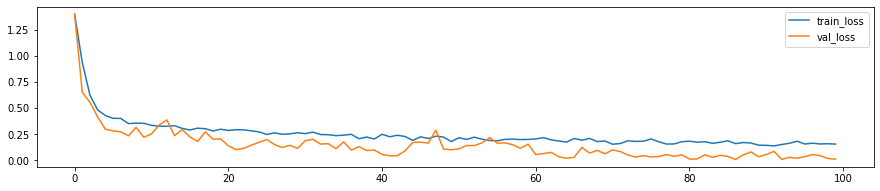

In [ ]:
show_training_loss(train_results)

## Validation score

In [ ]:
def show_valid_score(train_result):
    plt.figure(figsize=(15,10))
    plt.subplot(3,1,1)
    valid_score = train_result['valid_score']
    plt.plot(valid_score.index, valid_score, label = 'valid_score')
    plt.legend()

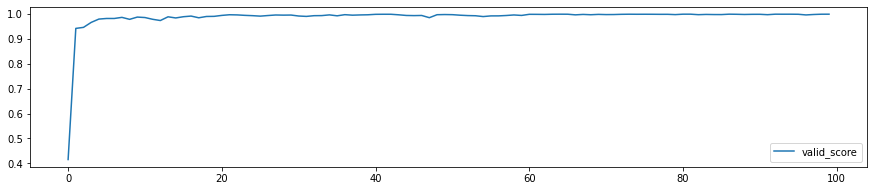

In [ ]:
show_valid_score(train_results)

In [ ]:
submission_df[['healthy', 'multiple_diseases', 'rust', 'scab']] = torch.softmax(submissions, dim=1)
submission_df.to_csv('submission.csv', index=False)
submission_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,8.943476e-05,1.344406e-01,0.865469,1.307268e-06
1,Test_1,7.985504e-07,2.255959e-04,0.999774,5.724193e-08
2,Test_2,5.291746e-05,3.371784e-05,0.000003,9.999102e-01
3,Test_3,9.970843e-01,7.388524e-07,0.002909,5.964645e-06
4,Test_4,2.132053e-04,1.930658e-03,0.997845,1.103669e-05
